In [204]:
import random
# Install required libraries
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
device = "cpu"
print(device)
CUDA_LAUNCH_BLOCKING=1

cpu


In [250]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):

      self.observation_space = spaces.Discrete(36)
      self.action_space = spaces.Discrete(6)
      self.max_timesteps = 150

      self.timestep = 0
      self.agent_pos = [0, 0]
      self.goal_pos = [5, 5]
      self.package_pos = [3, 1]
      self.state = np.zeros((6,6))
      #Shelves
      self.wall_1 = [3,2]
      self.wall_2 = [4,2]
      self.wall_3 = [5,2]
      self.wall_4 = [1,4]
      self.wall_5 = [1,5]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12

      self.package = 0
      self.pickup = 0

    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((6,6))
      self.agent_pos = [0, 0]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.timestep = 0
      observation = self.state.flatten()
      self.package =0
      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
      prev = self.agent_pos.copy()
      if action == 0: #down
        self.agent_pos[0] += 1
      if action == 1: #up
        self.agent_pos[0] -= 1
      if action == 2: #right
        self.agent_pos[1] += 1
      if action == 3: #left
        self.agent_pos[1] -= 1

      reward = -1
      if action == 4: # Pick up
        if np.array_equal(self.agent_pos, self.package_pos) and self.package == 0: #Picked up, in right location
          self.package = 1
          reward = 200
          #print("\n----picked up----\n", self.timestep)
          #self.pickup += 1
        elif self.package: #Picked up while holding a package
          reward = -15
        else: # Picked up in wrong location
          reward = -10

      if action == 5:
        #Drop off
        if np.array_equal(self.agent_pos, self.goal_pos) and self.package == 1: #Dropped off in right location
          reward = 200
          print("----dropped off----", self.timestep)
          self.package = 0
          self.timestep = self.max_timesteps
        elif self.package == 0: #Dropped off without holding a package
          reward = -15
        else: #dropped off in wrong location
          reward = -10

      if np.array_equal(self.agent_pos, self.wall_1) or np.array_equal(self.agent_pos, self.wall_2) or np.array_equal(self.agent_pos, self.wall_3) or np.array_equal(self.agent_pos, self.wall_4) or np.array_equal(self.agent_pos, self.wall_5):
        reward = -20
        self.agent_pos = prev

      # Comment this to demonstrate the truncation condition.
      if self.agent_pos[0] > 5 or self.agent_pos[0] < 0 or self.agent_pos[1] > 5 or self.agent_pos[1] < 0:
        reward = -15
        #print("bounding: ", self.agent_pos)
      self.agent_pos = np.clip(self.agent_pos, 0, 5)

      self.state = np.zeros((6,6))
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.state[tuple(self.agent_pos)] = 50
      observation = self.state.flatten()


      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if self.timestep >= self.max_timesteps else False

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = True if np.all((np.asarray(self.agent_pos) >=0 ) & (np.asarray(self.agent_pos) <= 6)) else False
      #print(self.agent_pos)

      return observation, reward, terminated, self.package

    # Render function: Visualizes the environment
    def render(self):
      plt.title('Grid Environment')
      plt.imshow(self.state)

In [227]:
class Net(nn.Module):

    def __init__(self, obs, action):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(obs, 64)
        self.layer2 = nn.Linear(64, action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        return self.layer2(x)

In [266]:
class DQN:
  # initialize values
  def __init__(self, N, C, learning_rate):
    # initialize environment
    self.env = GridEnvironment()
    # initialize replay memory to capacity N
    self.replay = [None] * N
    self.capacity = N
    self.pointer = 0
    self.policy_net = Net(2, 6).to(device)
    self.target_net = Net(2, 6).to(device)
    self.optimizer = optim.Adam(self.policy_net.parameters(), amsgrad=True)

    self.C = C

  
  # Main training function
  def train(self, episodes, epsilon, gamma, action_function, greedy):
    total_reward = [0] * episodes  
    for i in range(episodes):
      # initialize sequence S and preprocessed sequence o
      state = torch.tensor([0, 0],device=device, dtype=torch.float32).unsqueeze(0)
      terminated = False
      pos = package = rewards = steps = 0
      # Decay epsilon after every episode
      eps = epsilon ** i if not greedy else 0
      self.env.reset()
      while not terminated:
        # Select action
        action_type = action_function(eps, pos, package)

        # Execute action and observe reward
        position, reward, terminated, package = self.env.step(action_type)
        pos = np.where(position == 50)[0][0]

        # Format next state
        next_state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)

        # # # See greedy steps (Might be going back and forth)
        # s = state[0][0].item()
        # if greedy:
        #     print(f"{s} -> {pos}")

        # Add to total rewards for the episode
        rewards += reward
        # Encode action type for ease of use
        action_type = torch.tensor([action_type], device=device, dtype=torch.int64)
        # store transition in replay buffer
        transition = state, action_type,  next_state, reward
        state = next_state


        self.replay[self.pointer % self.capacity] = transition
        self.pointer += 1

        # When terminated store the last value found
        if terminated:
            transition = state, action_type,  None, reward
            self.replay[self.pointer % self.capacity] = transition
            self.pointer += 1
            
        batch_size = 128
        # Run the replay function if there is enough transitions
        if batch_size < self.pointer:
            self.replay_function(gamma ** steps, batch_size)

        # Every C steps batch
        if steps % self.C == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            
        steps += 1
      print("Episode: ", i, " Reward: ", rewards)
      total_reward[i] = rewards  
    return total_reward
  # Determine the action for the warehouse environment
  def warehouse_action(self, epsilon, pos, package):
      if np.random.rand() < epsilon:
        action_type = np.random.randint(6)
      else:
        with torch.no_grad():
            state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)
            action_type = self.policy_net(state).max(1).indices.item()
      return action_type
      
  def replay_function(self, gamma, batch_size):
    if self.pointer < self.capacity:
        temp = self.replay[:self.pointer]
        sample = random.sample(temp, k=batch_size)
    else:
        sample = random.sample(self.replay, k=batch_size)
    Q_list = torch.tensor([] , device=device)
    target_val = torch.tensor([] , device=device)
    action_list = torch.tensor([], dtype=torch.int64, device=device)
    for state, action, next_state, reward in sample:
        if next_state is None:
            Q_list = torch.cat((Q_list, self.policy_net(state)))
            # Make an actions array
            action_list = torch.cat((action_list, action), 0)
            # Calculate updated Q value
            Q_val = torch.tensor([reward], device=device)
            # Add value to expected target list
            target_val = torch.cat((target_val, Q_val))
            
        else:
            # Take entire Q row
            Q_list = torch.cat((Q_list, self.policy_net(state)))
            # Make an actions array
            action_list = torch.cat((action_list, action), 0)
            # Take max expected Q from the target network
            max_expected = self.target_net(next_state).max(1).values
            
            # Calculate updated Q value
            Q_val = torch.tensor([(max_expected * gamma) + reward], device=device)
            # Add value to expected target list
            target_val = torch.cat((target_val, Q_val))

    # Apply the action list to get real expected Q values
    selected_q_values = Q_list.gather(1, action_list.unsqueeze(1))


    loss_function = nn.MSELoss()
    loss = loss_function(selected_q_values, target_val.unsqueeze(1))
    #backprop
    self.optimizer.zero_grad()
    loss.backward()
    
    self.optimizer.step()

              

  # Save the current weights
  def save(self, filename):
    with open("pickles/" + filename, 'wb') as file:
      pickle.dump(self.policy_net, file)


In [215]:
#Prints the reward per episode graph
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) - abs(int(min(reward_per_episode)) * (.2))
    maxs = int(max(reward_per_episode)) + abs(int(max(reward_per_episode)) * (.3) )
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

def print_Qtable(policy):
    for pos in range(36):
        for package in range(2):
            state = torch.tensor([pos, package],device=device, dtype=torch.float32).unsqueeze(0)
            table = policy(state).squeeze(1)[0]
            ret = f"({pos}, {package}):\n0:{table[0].item()}, 1:{table[1].item()}, 2:{table[2].item()}, 3:{table[3].item()}, 4:{table[4].item()}, 5:{table[5].item()}"
            print(ret)


Episode:  0  Reward:  -756
Episode:  1  Reward:  -1119
Episode:  2  Reward:  -1223
Episode:  3  Reward:  -1325
Episode:  4  Reward:  -1126
Episode:  5  Reward:  -1017
Episode:  6  Reward:  -1079
Episode:  7  Reward:  -1156
Episode:  8  Reward:  -1072
Episode:  9  Reward:  -1116
Episode:  10  Reward:  -1156
Episode:  11  Reward:  -1188
Episode:  12  Reward:  -789
Episode:  13  Reward:  -824
----dropped off---- 100
Episode:  14  Reward:  -249
Episode:  15  Reward:  -892
Episode:  16  Reward:  -759
Episode:  17  Reward:  -859
Episode:  18  Reward:  -915
Episode:  19  Reward:  -726
Episode:  20  Reward:  -766
Episode:  21  Reward:  -969
Episode:  22  Reward:  -751
Episode:  23  Reward:  -990
Episode:  24  Reward:  -950
Episode:  25  Reward:  -986
Episode:  26  Reward:  -967
Episode:  27  Reward:  -822
Episode:  28  Reward:  -750
Episode:  29  Reward:  -871
Episode:  30  Reward:  -851
Episode:  31  Reward:  -897
Episode:  32  Reward:  -719
Episode:  33  Reward:  -999
Episode:  34  Reward:  

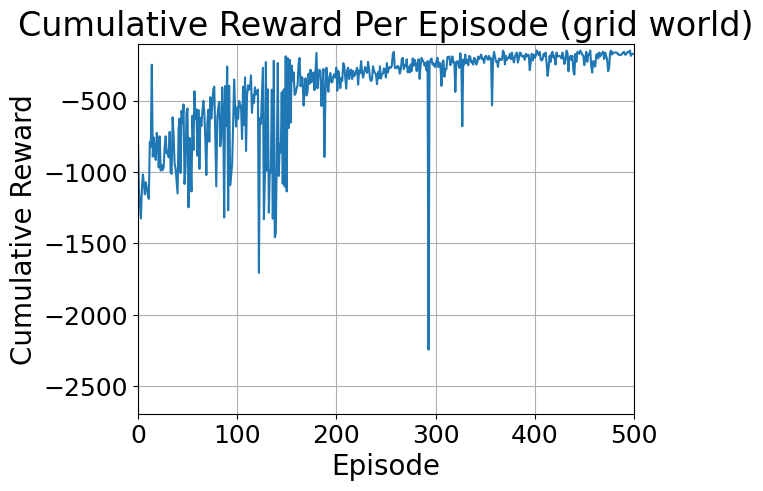

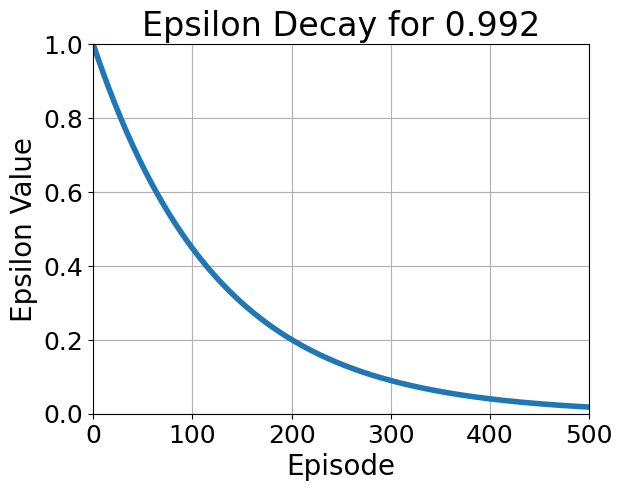

Episode:  0  Reward:  -150
Episode:  1  Reward:  -206
Episode:  2  Reward:  -150
Episode:  3  Reward:  -150
Episode:  4  Reward:  -150
Episode:  5  Reward:  -150


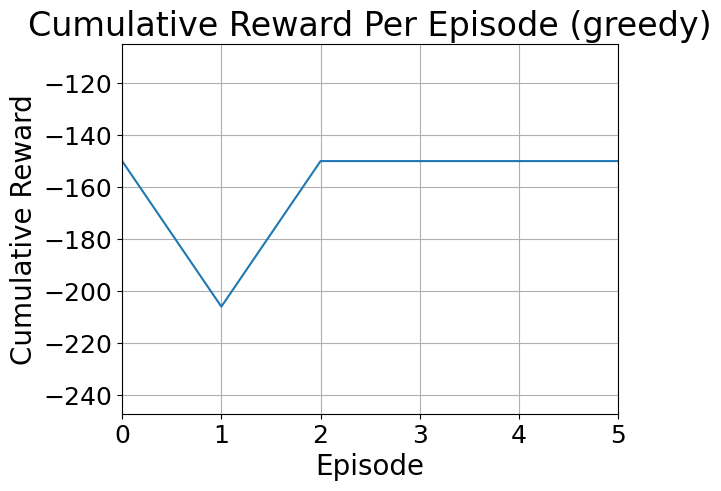

In [260]:
N = 5000
C = 10
learning_rate = 0.1
agent = DQN(N, C, learning_rate)

episodes = 500
epsilon = .992
discount = .9
action = agent.warehouse_action
total_rewards = agent.train(episodes, epsilon, discount, action, False)
print("Best reward: ", max(total_rewards))
agent.save("drpreisl_angustsa_assignment2_part2_dqn_gridworld.pickle")
reward_print(total_rewards, episodes, "grid world")
ep_decay(epsilon, episodes)
total_rewards = agent.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "greedy")

In [269]:
filename = "drpreisl_angustsa_assignment2_part2_dqn_gridworld.pickle"
with open("pickles/" + filename, 'wb') as file:
    pickle.dump(agent.policy_net.state_dict(), file)


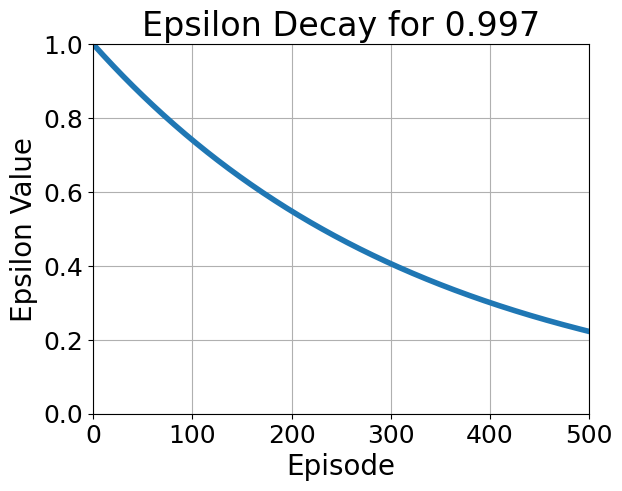

In [264]:
ep_decay(.997, 500)
